# **Mount drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
root_path = '/content/drive/MyDrive/ColabNotebooks/zindi/AirQoLowCost/'

#**Importing libraries**

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

#**Read files**

In [4]:
# Load files into a pandas dataframe
train = pd.read_csv(root_path + 'Train.csv')
test = pd.read_csv(root_path + 'Test.csv')
ss = pd.read_csv(root_path + 'SampleSubmission.csv')

In [5]:
train.shape

(10932, 18)

In [6]:
test.shape

(2733, 17)

#**Data Preprocessing**

In [7]:
# Preview the first five rows of the train set
train.head()

,ID,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,ref_pm2_5
0,ID_0038MG0B,2020-04-23 17:00:00+03:00,USEmbassy,6.819048,7.313810,6.794048,7.838333,0.807417,22.383333,0.299255,32.592686,1199,4374,21,14,6834,130,25.0
1,ID_008ASVDD,2020-02-23 19:00:00+03:00,USEmbassy,57.456047,67.883488,55.643488,70.646977,0.712417,25.350000,0.299255,32.592686,1199,4374,21,14,6834,130,68.0
2,ID_009ACJQ9,2021-01-23 04:00:00+03:00,Nakawa,170.009773,191.153636,165.308636,191.471591,0.907833,20.616667,0.331740,32.609510,1191,5865,31,-11,4780,500,149.7
3,ID_00IGMAQ2,2019-12-04 09:00:00+03:00,USEmbassy,49.732821,61.512564,0.000000,0.000000,0.949667,21.216667,0.299255,32.592686,1199,4374,21,14,6834,130,54.0
4,ID_00P76VAQ,2019-10-01 01:00:00+03:00,USEmbassy,41.630455,51.044545,41.725000,51.141364,0.913833,18.908333,0.299255,32.592686,1199,4374,21,14,6834,130,39.0


In [8]:
# Preview the first five rows of the test set
test.head()

,ID,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road
0,ID_00OZLF7X,2020-03-13 07:00:00+03:00,USEmbassy,31.900455,35.515455,31.672273,37.051818,0.927167,21.175000,0.299255,32.592686,1199,4374,21,14,6834,130
1,ID_00ZI0D98,2020-08-08 10:00:00+03:00,Makerere,53.581818,66.603636,50.586364,64.651818,0.811583,22.350000,0.333501,32.568561,1233,6340,21,28,8518,475
2,ID_017GTLAU,2020-08-25 09:00:00+03:00,Makerere,62.377500,71.647500,59.023333,69.766667,0.902000,20.766667,0.333501,32.568561,1233,6340,21,28,8518,475
3,ID_01IBM7T2,2020-06-15 16:00:00+03:00,USEmbassy,33.310294,36.958824,33.060882,38.674412,0.643417,25.483333,0.299255,32.592686,1199,4374,21,14,6834,130
4,ID_01II27D4,2021-01-13 00:00:00+03:00,Nakawa,64.782045,75.247500,64.638182,77.108864,0.939667,20.133333,0.331740,32.609510,1191,5865,31,-11,4780,500


In [9]:
# Preview the first five rows of the sample submission file
ss.head()

,ID,ref_pm2_5
0,ID_00OZLF7X,NaN
1,ID_00ZI0D98,NaN
2,ID_017GTLAU,NaN
3,ID_01IBM7T2,NaN
4,ID_01II27D4,NaN


In [10]:
data = train

#**Data preprocessing STEP BY STEP**

### Columns

In [11]:
data.columns

Index(['ID', 'created_at', 'site', 'pm2_5', 'pm10', 's2_pm2_5', 's2_pm10',
       'humidity', 'temp', 'lat', 'long', 'altitude', 'greenness',
       'landform_90m', 'landform_270m', 'population', 'dist_major_road',
       'ref_pm2_5'],
      dtype='object')

### Checking the types

In [12]:
data.dtypes

ID                  object
created_at          object
site                object
pm2_5              float64
pm10               float64
s2_pm2_5           float64
s2_pm10            float64
humidity           float64
temp               float64
lat                float64
long               float64
altitude             int64
greenness            int64
landform_90m         int64
landform_270m        int64
population           int64
dist_major_road      int64
ref_pm2_5          float64
dtype: object

### Inspecting unique values

In [13]:
data['created_at'].unique()
len(data['created_at'].unique())

9147

In [14]:
data['site'].unique()

array(['USEmbassy', 'Nakawa', 'Makerere'], dtype=object)

In [15]:
data['greenness'].unique()

array([4374, 5865, 6340])

In [16]:
data['dist_major_road'].unique()

array([130, 500, 475])

In [17]:
data['population'].unique()

array([6834, 4780, 8518])

### Plots - Visualizations

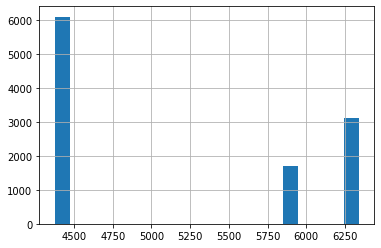

In [18]:

# histograms of discrete variables often show
# a bar plot shape, instead of continuous intervals

data['greenness'].hist(bins=20)

In [19]:
col_hist = ['pm2_5', 'pm10', 's2_pm2_5', 's2_pm10', 'humidity', 'temp', 'lat', 'long', 'altitude', 'greenness', 'landform_90m', 'landform_270m', 'population', 'dist_major_road', 'ref_pm2_5']

In [20]:
data_for_hist = data.drop(['ID', 'created_at', 'site'], axis=1)

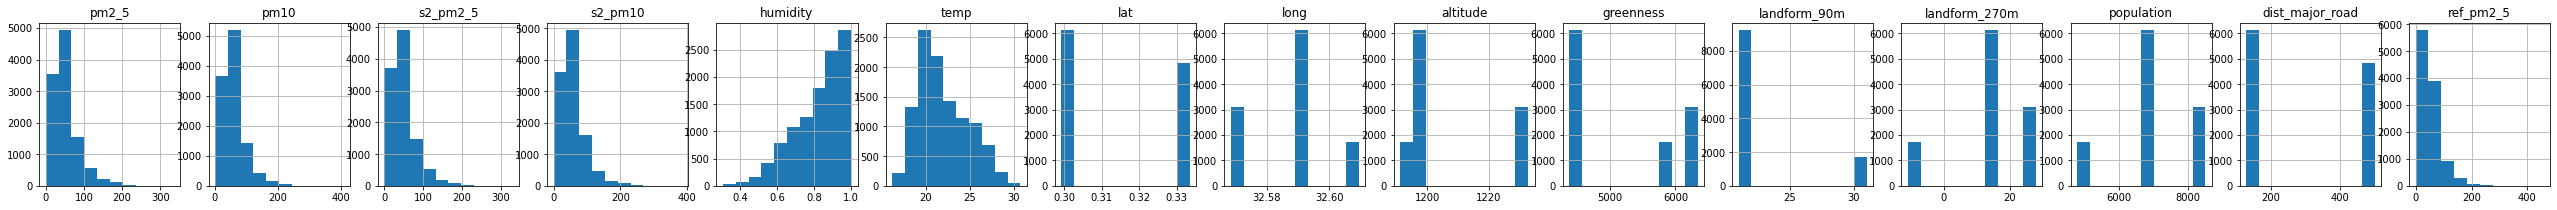

In [21]:
fig, ax = plt.subplots(1, len(col_hist), figsize=(3*len(col_hist), 3))
for i, var in enumerate(data_for_hist):
    data[var].hist(ax=ax[i])
    ax[i].set_title(var)
plt.show()

### Dealing with missing data

In [22]:
# we can quantify the total number of missing values using
# the isnull() method plus the sum() method on the dataframe

data.isnull().sum()

ID                  0
created_at          0
site                0
pm2_5               0
pm10                0
s2_pm2_5            0
s2_pm10             0
humidity            6
temp               17
lat                 0
long                0
altitude            0
greenness           0
landform_90m        0
landform_270m       0
population          0
dist_major_road     0
ref_pm2_5           0
dtype: int64

In [23]:
# the dataset contains empty strings
# which are in essence missing values
# I replace those here
data = data.replace(' ', np.nan)

# let's inspect the first 5 rows
data.head()

,ID,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,ref_pm2_5
0,ID_0038MG0B,2020-04-23 17:00:00+03:00,USEmbassy,6.819048,7.313810,6.794048,7.838333,0.807417,22.383333,0.299255,32.592686,1199,4374,21,14,6834,130,25.0
1,ID_008ASVDD,2020-02-23 19:00:00+03:00,USEmbassy,57.456047,67.883488,55.643488,70.646977,0.712417,25.350000,0.299255,32.592686,1199,4374,21,14,6834,130,68.0
2,ID_009ACJQ9,2021-01-23 04:00:00+03:00,Nakawa,170.009773,191.153636,165.308636,191.471591,0.907833,20.616667,0.331740,32.609510,1191,5865,31,-11,4780,500,149.7
3,ID_00IGMAQ2,2019-12-04 09:00:00+03:00,USEmbassy,49.732821,61.512564,0.000000,0.000000,0.949667,21.216667,0.299255,32.592686,1199,4374,21,14,6834,130,54.0
4,ID_00P76VAQ,2019-10-01 01:00:00+03:00,USEmbassy,41.630455,51.044545,41.725000,51.141364,0.913833,18.908333,0.299255,32.592686,1199,4374,21,14,6834,130,39.0


In [24]:

# alternatively, we can use the mean() method after isnull()
# to visualise the percentage of missing values for each variable

data.isnull().mean()

ID                 0.000000
created_at         0.000000
site               0.000000
pm2_5              0.000000
pm10               0.000000
s2_pm2_5           0.000000
s2_pm10            0.000000
humidity           0.000549
temp               0.001555
lat                0.000000
long               0.000000
altitude           0.000000
greenness          0.000000
landform_90m       0.000000
landform_270m      0.000000
population         0.000000
dist_major_road    0.000000
ref_pm2_5          0.000000
dtype: float64

Text(0.5, 1.0, 'Quantifying missing data')

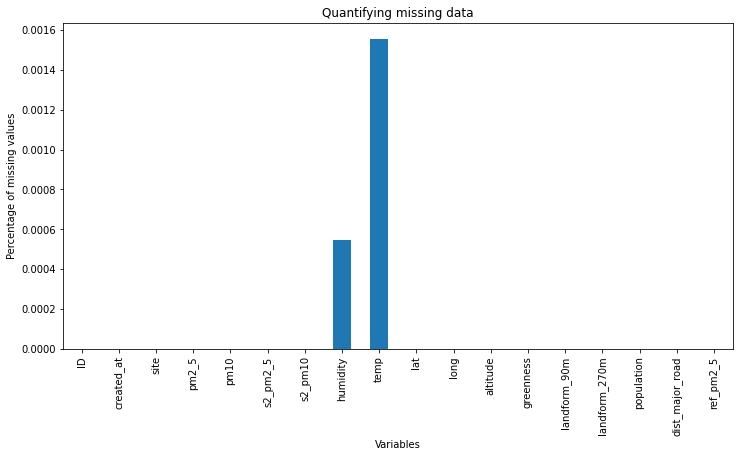

In [25]:

# we can also plot the percentages of missing data utilising
# pandas plot.bar(), and add labels with matplotlib methods 
# as shown below

data.isnull().mean().plot.bar(figsize=(12,6))
plt.ylabel('Percentage of missing values')
plt.xlabel('Variables')
plt.title('Quantifying missing data')

### Determining cardinality

In [26]:
# with the following command we can learn the cardinality
# of each of the loaded variables

data.nunique()

ID                 10932
created_at          9147
site                   3
pm2_5              10909
pm10               10914
s2_pm2_5           10407
s2_pm10            10418
humidity            4288
temp                1577
lat                    3
long                   3
altitude               3
greenness              3
landform_90m           2
landform_270m          3
population             3
dist_major_road        3
ref_pm2_5           1233
dtype: int64

Text(0.5, 1.0, 'Cardinality')

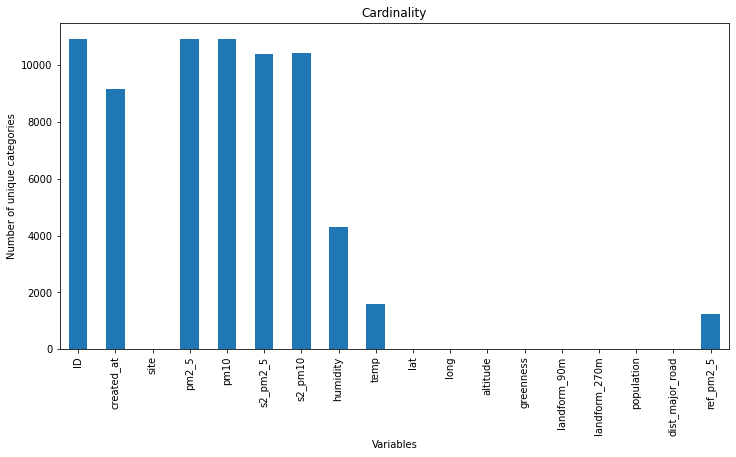

In [27]:
# let's plot the cardinality of the variables 

data.nunique().plot.bar(figsize=(12,6))

# add labels and title
plt.ylabel('Number of unique categories')
plt.xlabel('Variables')
plt.title('Cardinality')

### Identifying-a-linear-relationship

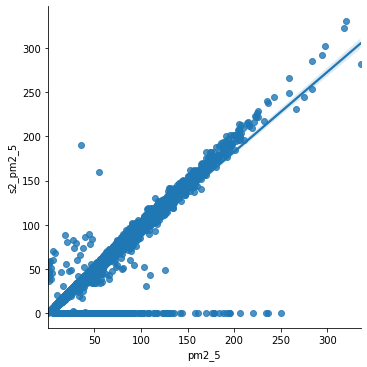

In [28]:
#now we make a scatter plot for the boston
# house price dataset

# we plot the variable LAST (% lower status of the population)
# vs the target MEDV (median value of the house)

sns.lmplot(x="pm2_5", y="s2_pm2_5", data=data, order=1)


### Distinguish variables distributions

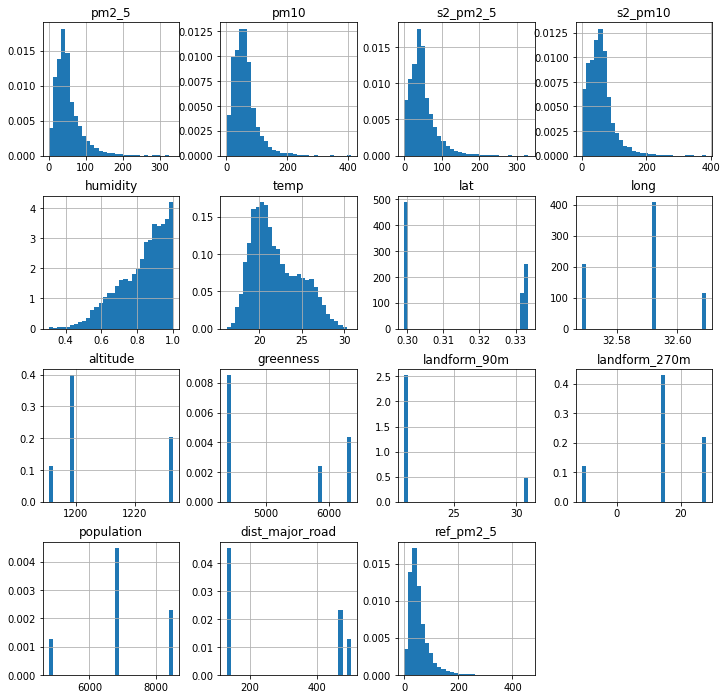

In [29]:
data_for_hist.hist(bins=30, figsize=(12,12), density=True)
plt.show()

### Highlighting-outliers

Text(0.5, 1.0, 'Boxplot')

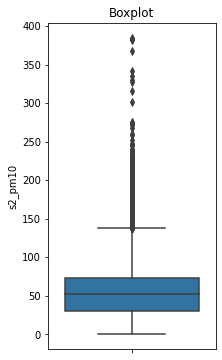

In [30]:
# boxplot
plt.figure(figsize=(3,6))
sns.boxplot(y=data['s2_pm10'])
plt.title('Boxplot')

### Comparing feature magnitude

In [31]:
# let's now calculate the range of the variables

data_for_hist.max() - data_for_hist.min()

pm2_5               334.865751
pm10                407.118044
s2_pm2_5            330.275152
s2_pm10             384.627045
humidity              0.692833
temp                 14.606818
lat                   0.034246
long                  0.040949
altitude             42.000000
greenness          1966.000000
landform_90m         10.000000
landform_270m        39.000000
population         3738.000000
dist_major_road     370.000000
ref_pm2_5           458.900000
dtype: float64

### Change cathegorical variables to integers

In [32]:
data['site'].unique()

array(['USEmbassy', 'Nakawa', 'Makerere'], dtype=object)

In [33]:
data['site'] = data['site'].map({'USEmbassy':0, 'Nakawa':1, 'Makerere':2})

In [34]:
#data = data.drop(['created_at'], axis=1)
data.head()

,ID,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,ref_pm2_5
0,ID_0038MG0B,2020-04-23 17:00:00+03:00,0,6.819048,7.313810,6.794048,7.838333,0.807417,22.383333,0.299255,32.592686,1199,4374,21,14,6834,130,25.0
1,ID_008ASVDD,2020-02-23 19:00:00+03:00,0,57.456047,67.883488,55.643488,70.646977,0.712417,25.350000,0.299255,32.592686,1199,4374,21,14,6834,130,68.0
2,ID_009ACJQ9,2021-01-23 04:00:00+03:00,1,170.009773,191.153636,165.308636,191.471591,0.907833,20.616667,0.331740,32.609510,1191,5865,31,-11,4780,500,149.7
3,ID_00IGMAQ2,2019-12-04 09:00:00+03:00,0,49.732821,61.512564,0.000000,0.000000,0.949667,21.216667,0.299255,32.592686,1199,4374,21,14,6834,130,54.0
4,ID_00P76VAQ,2019-10-01 01:00:00+03:00,0,41.630455,51.044545,41.725000,51.141364,0.913833,18.908333,0.299255,32.592686,1199,4374,21,14,6834,130,39.0


In [35]:
# find categorical variables
cat_cols = [c for c in data.columns if data[c].dtypes=='O']
data[cat_cols].head()

,ID,created_at
0,ID_0038MG0B,2020-04-23 17:00:00+03:00
1,ID_008ASVDD,2020-02-23 19:00:00+03:00
2,ID_009ACJQ9,2021-01-23 04:00:00+03:00
3,ID_00IGMAQ2,2019-12-04 09:00:00+03:00
4,ID_00P76VAQ,2019-10-01 01:00:00+03:00


In [36]:
# find numerical variables

num_cols = [c for c in data.columns if data[c].dtypes!='O']
data[num_cols].head()

,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,ref_pm2_5
0,0,6.819048,7.313810,6.794048,7.838333,0.807417,22.383333,0.299255,32.592686,1199,4374,21,14,6834,130,25.0
1,0,57.456047,67.883488,55.643488,70.646977,0.712417,25.350000,0.299255,32.592686,1199,4374,21,14,6834,130,68.0
2,1,170.009773,191.153636,165.308636,191.471591,0.907833,20.616667,0.331740,32.609510,1191,5865,31,-11,4780,500,149.7
3,0,49.732821,61.512564,0.000000,0.000000,0.949667,21.216667,0.299255,32.592686,1199,4374,21,14,6834,130,54.0
4,0,41.630455,51.044545,41.725000,51.141364,0.913833,18.908333,0.299255,32.592686,1199,4374,21,14,6834,130,39.0


### Removing-observations-with-missing-data

In [37]:
# let's inspect the percentage of missing values in each variable

data.isnull().mean().sort_values(ascending=True)

ID                 0.000000
population         0.000000
landform_270m      0.000000
landform_90m       0.000000
greenness          0.000000
altitude           0.000000
long               0.000000
lat                0.000000
ref_pm2_5          0.000000
s2_pm10            0.000000
s2_pm2_5           0.000000
pm10               0.000000
pm2_5              0.000000
site               0.000000
created_at         0.000000
dist_major_road    0.000000
humidity           0.000549
temp               0.001555
dtype: float64

In [38]:
# create a complete case data set

data_cca = data.dropna()

In [39]:
print('Number of total observations: {}'.format(len(data)))
print('Number of observations with complete cases: {}'.format(len(data_cca)))

Number of total observations: 10932
Number of observations with complete cases: 10911


In [40]:
data_cca.isnull().mean().sort_values(ascending=True)

ID                 0.0
population         0.0
landform_270m      0.0
landform_90m       0.0
greenness          0.0
altitude           0.0
long               0.0
lat                0.0
temp               0.0
humidity           0.0
s2_pm10            0.0
s2_pm2_5           0.0
pm10               0.0
pm2_5              0.0
site               0.0
created_at         0.0
dist_major_road    0.0
ref_pm2_5          0.0
dtype: float64

### PCA

In [122]:
data_cca.columns

Index(['ID', 'created_at', 'site', 'pm2_5', 'pm10', 's2_pm2_5', 's2_pm10',
       'humidity', 'temp', 'lat', 'long', 'altitude', 'greenness',
       'landform_90m', 'landform_270m', 'population', 'dist_major_road',
       'ref_pm2_5'],
      dtype='object')

In [123]:
from sklearn.preprocessing import StandardScaler
features = ['site', 'pm2_5', 'pm10', 's2_pm2_5', 's2_pm10','humidity', 'temp', 'lat', 'long', 'altitude', 'greenness','landform_90m', 'landform_270m', 'population', 'dist_major_road']
# Separating out the features
newX = data_cca.loc[:, features].values
# Separating out the target
newY = data_cca.loc[:,['ref_pm2_5']].values
# Standardizing the features
newX = StandardScaler().fit_transform(newX)

In [124]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(newX)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'])

In [125]:
finalDf = pd.concat([principalDf, data_cca['ref_pm2_5']], axis = 1)

In [126]:
finalDf.isnull().any()

principal component 1    True
principal component 2    True
principal component 3    True
principal component 4    True
ref_pm2_5                True
dtype: bool

In [127]:
finalDf = finalDf.fillna(method='ffill')

In [128]:
finalDf.isnull().any()

principal component 1    False
principal component 2    False
principal component 3    False
principal component 4    False
ref_pm2_5                False
dtype: bool

In [129]:
np.sum(pca.explained_variance_ratio_)

0.9800538220092638

In [130]:
from sklearn.linear_model import LogisticRegression

In [131]:
logisticRegr = LogisticRegression(solver = 'lbfgs')

In [132]:
newX_train, newX_test, newy_train, newy_test = train_test_split(finalDf.drop(['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'], axis=1), finalDf['ref_pm2_5'], test_size=0.30, random_state=42)

In [133]:
finalDf.describe

<bound method NDFrame.describe of        principal component 1  ...  ref_pm2_5
0                  -1.868867  ...       25.0
1                  -1.456019  ...       68.0
2                  -0.358321  ...      149.7
3                  -1.694430  ...       54.0
4                  -1.499789  ...       39.0
...                      ...  ...        ...
10927              -1.688980  ...       77.0
10928              -1.688980  ...       22.0
10929              -1.688980  ...       34.0
10930              -1.688980  ...       34.8
10931              -1.688980  ...       48.0

[10932 rows x 5 columns]>

#**Splitting data**

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(data_cca.drop(['ID', 'ref_pm2_5', 'created_at'], axis=1), data_cca['ref_pm2_5'], test_size=0.30, random_state=42)

In [43]:
#y_train = y_train.to_frame()

In [44]:
#y_test = y_test.to_frame()

In [45]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7637, 15) (7637,) (3274, 15) (3274,)


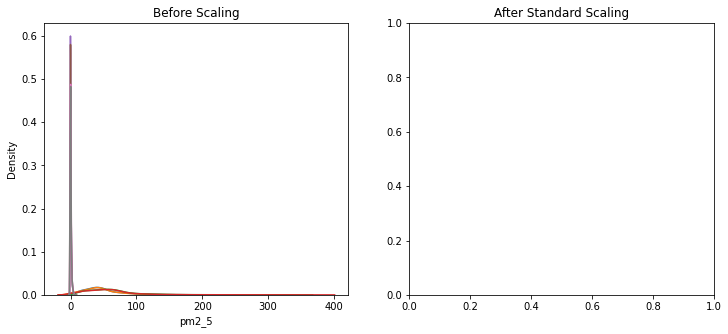

In [66]:
# let's compare the variable distributions before and after scaling

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# before scaling
ax1.set_title('Before Scaling')
sns.kdeplot(X_train['pm2_5'], ax=ax1)
sns.kdeplot(X_train['s2_pm2_5'], ax=ax1)
sns.kdeplot(X_train['pm10'], ax=ax1)
sns.kdeplot(X_train['s2_pm10'], ax=ax1)

# after scaling
ax2.set_title('After Standard Scaling')
sns.kdeplot(X_train_scaled['pm2_5'], ax=ax1)
sns.kdeplot(X_train_scaled['s2_pm2_5'], ax=ax1)
sns.kdeplot(X_train_scaled['pm10'], ax=ax1)
sns.kdeplot(X_train_scaled['s2_pm10'], ax=ax1)
plt.show()

#**Building model**

### Train the model

In [135]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, Perceptron
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

reg = LinearRegression()

reg.fit(newX_train, newy_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [137]:
reg.score(newX_test, newy_test)

1.0

### Make predictions on the test set

In [55]:
test

,ID,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road
0,ID_00OZLF7X,2020-03-13 07:00:00+03:00,USEmbassy,31.900455,35.515455,31.672273,37.051818,0.927167,21.175000,0.299255,32.592686,1199,4374,21,14,6834,130
1,ID_00ZI0D98,2020-08-08 10:00:00+03:00,Makerere,53.581818,66.603636,50.586364,64.651818,0.811583,22.350000,0.333501,32.568561,1233,6340,21,28,8518,475
2,ID_017GTLAU,2020-08-25 09:00:00+03:00,Makerere,62.377500,71.647500,59.023333,69.766667,0.902000,20.766667,0.333501,32.568561,1233,6340,21,28,8518,475
3,ID_01IBM7T2,2020-06-15 16:00:00+03:00,USEmbassy,33.310294,36.958824,33.060882,38.674412,0.643417,25.483333,0.299255,32.592686,1199,4374,21,14,6834,130
4,ID_01II27D4,2021-01-13 00:00:00+03:00,Nakawa,64.782045,75.247500,64.638182,77.108864,0.939667,20.133333,0.331740,32.609510,1191,5865,31,-11,4780,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2728,ID_ZW5RSNUS,2021-02-18 03:00:00+03:00,Makerere,43.508889,53.786667,42.747778,53.457778,0.924833,22.358333,0.333501,32.568561,1233,6340,21,28,8518,475
2729,ID_ZWCI817N,2021-01-21 23:00:00+03:00,Nakawa,101.348049,114.076098,99.469512,116.441220,0.936333,20.500000,0.331740,32.609510,1191,5865,31,-11,4780,500
2730,ID_ZX5858FJ,2020-12-12 21:00:00+03:00,Makerere,47.248182,59.862727,46.526364,59.971818,0.857917,20.966667,0.333501,32.568561,1233,6340,21,28,8518,475
2731,ID_ZY4XOL2H,2021-02-08 02:00:00+03:00,USEmbassy,217.070465,264.880698,220.803488,249.663953,0.716833,22.158333,0.299255,32.592686,1199,4374,21,14,6834,130


In [56]:
test = test.fillna(test.mean())

In [57]:
test_data = test.drop(['ID', 'created_at'], axis=1)

In [58]:
test_data['site'] = test_data['site'].map({'USEmbassy':0, 'Nakawa':1, 'Makerere':2})

In [59]:
test_data.isnull().sum()

site               0
pm2_5              0
pm10               0
s2_pm2_5           0
s2_pm10            0
humidity           0
temp               0
lat                0
long               0
altitude           0
greenness          0
landform_90m       0
landform_270m      0
population         0
dist_major_road    0
dtype: int64

### arrange testdata

In [144]:
newX_test.shape

(3280, 1)

In [143]:
features = ['site', 'pm2_5', 'pm10', 's2_pm2_5', 's2_pm10','humidity', 'temp', 'lat', 'long', 'altitude', 'greenness','landform_90m', 'landform_270m', 'population', 'dist_major_road']
# Separating out the features
newtest_data = test_data.loc[:, features].values
newtest_data = StandardScaler().fit_transform(newtest_data)
newtest_data.shape

(2733, 15)

In [145]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(newtest_data)
principalDftest = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'])

In [146]:
principalDftest.isnull().any()

principal component 1    False
principal component 2    False
principal component 3    False
principal component 4    False
dtype: bool

In [147]:
predictions = reg.predict(principalDftest)

ValueError: ignored

In [140]:
predictions

array([ 36.4453125 ,  42.9921875 ,  43.1953125 , ...,  36.046875  ,
       229.90234375,  97.23046875])

In [62]:
mean_squared_error(y_test, reg.predict(X_test), squared=False)

18.310609173221753

#**Submission**

In [63]:
# Create a submission file
sub_file = ss.copy()
sub_file['ref_pm2_5'] = predictions

In [64]:
sub_file

,ID,ref_pm2_5
0,ID_00OZLF7X,36.445312
1,ID_00ZI0D98,42.992188
2,ID_017GTLAU,43.195312
3,ID_01IBM7T2,48.546875
4,ID_01II27D4,63.804688
...,...,...
2728,ID_ZW5RSNUS,27.218750
2729,ID_ZWCI817N,95.281250
2730,ID_ZX5858FJ,36.046875
2731,ID_ZY4XOL2H,229.902344


In [65]:
# Create a csv file and upload to zindi 
sub_file.to_csv(root_path + 'Submission.csv', index = False)